<h1>Time of flight Parameter Study</h1>

We want to study the time of flight for waves propagating in the X-mode in magnetised plasma. For this purpose we will be using the ```WavesPlasma``` library and we will be often taking after the ```X-mode Propagation Study``` notebook.

In [1]:
import numpy as np
import cmath as cm

from scipy.fft import fft,fftfreq
from scipy.interpolate import make_smoothing_spline

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython.display import clear_output

import copy
from timeit import default_timer as timer
import pandas as pd

np.random.seed(2024061) # For reproducibility

import import_ipynb
from WavesPlasma import *

Nx     = 2100
p0plas = 90
k00    = 0.025
ν      = 84 
wpe2_,wc_ = freq_dicts(Nx,k00,p0plas)
# Profile reconstruction
β    = 27.9

importing Jupyter notebook from WavesPlasma.ipynb


First of all let us introduce the theoretical background to our work developed by Roland Sabot.

Let us consider a plasma with linear density profiles and linear magnetic dependency.

\begin{align}
    \omega_{pe}^2(x)&=\omega_{p0}^2\frac{x}{L_n}\\
    \omega_{c}^2(x)&=\omega_{ca}^2\left(1+\frac{2x}{L_B}\right)
\end{align}

where $L_n$ and $L_B$ are called respectively the density and magnetic field gradient lengths. Note that $\omega_{p0}$ and $\omega_{ca}$ are reference frequencies. 

Let us discuss the usual values of these quantities. In the tokamatk WEST, the egde magnetic field is around $B_a=3$ T, meaning that $\omega_{ca} \approx 524\ \text{G}\frac{\text{rad}}{\text{s}}$, or a frequency of $\nu_{ca}=84$ GHz. This means that we will choose the probing frequency to be between $81$ and $87$ GHz, but more on that later. Similarly, the electron density at the edge is around $n_e=5\cdot10^{19}\ \text{m}^{-3}$, meaning that the pulsation is $\omega_{p0}\approx400\ \text{G}\frac{\text{rad}}{\text{s}}$, or a frequency of $\nu_{p}=63$ GHz. Hence we will take

\begin{equation}
    \frac{\omega_{ca}^2}{\omega_{p0}^2}=\frac{16}{9}
\end{equation}

Now, to retain the same level of spatial detail of the wave we will not change the numerical value of ```k00```, but we can choose which frequency it represents. To keep it centered, we will take $k_{00}\equiv84$ GHz $=\nu_{ca}$ (frequency and wavenumber equivalence details omitted as explained in other notebooks).

This leaves us needing only to set the values of $L_n$ and $L_B$. To do so we introduce the parameter $\eta_0$, which is a ratio describing the cavity that depends on the four values:

\begin{equation}
    \eta_0=2\left(\frac{\omega_{ca}^2}{L_B}\right)\left(\frac{\omega_{p0}^2}{L_n}\right)^{-1}=2\left(\frac{\omega_{ca}^2}{\omega_{p0}^2}\right)\left(\frac{L_n}{L_B}\right)\quad\in[0,\infty]
\end{equation}

It can be proved that the time of flight for a probing wave at cutoff frequency $\omega_{c0}$ for a cutoff at the very beginning of the cavity ($x_c\to0$) can be given by the following expression

\begin{equation}
    \tau\left(\omega_{c0},x_c\to0\right)=\frac{2L_B}{c}\cdot\eta_0\left(\frac{\sqrt{2-\eta_0}}{(1+\eta_0)^{3/2}}-\frac{\sinh^{-1}\sqrt{1+\eta_0}}{(1+\eta_0)^2}\right)
\end{equation}

This is the expression that we want to numerically verify for $\eta_0\in[0,10]$, or in other words,

\begin{equation}
    \eta_0=\frac{32}{9}\left(\frac{L_n}{L_B}\right)\quad\in[0,10]\quad\iff\quad \frac{L_n}{L_B}\in\left[0,\frac{90}{32}\right]
\end{equation}

Now, as we can not numerically set $x_c=0$, or there would be no simulation, we will run it for $x_c=10$. With this, knowing that the cutoff frequency $\omega_{c0}$ is given by the expression below, we can write the following.
\begin{align}
    \omega_{c0}(x)&=\frac{1}{2}\omega_{c}(x)+\frac{1}{2}\sqrt{\omega_c^2(x)+4\omega_{pe}^2(x)}\\
    &=\frac{1}{2}\omega_{ca}\sqrt{1+\frac{2x}{L_B}}+\frac{1}{2}\sqrt{\omega_{ca}^2\left(1+\frac{2x}{L_B}\right)+4\omega_{p0}^2\frac{x}{L_n}}\\
    &=\omega_{p0}\left[\frac{2}{3}\sqrt{1+\frac{2x}{L_B}}+\sqrt{\frac{4}{9}\left(1+\frac{2x}{L_B}\right)+\frac{x}{L_n}}\right]
\end{align}

we want this value to be in the $[81,87]$ GHz interval as we mentioned before, so we limit the possible values of $L_n$ and $L_B$. The determination of the range of values that verify these two conditions simultaneously is rather difficult to compute analytically, so we will do so numerically.

In [2]:
def wco_up(x,wp02,wca2,Ln,LB,p0plas):
    return 0.5*(wc_linear(x,wca2,LB,p0plas)+np.sqrt(wc_linear(x,wca2,LB,p0plas)**2+4*wpe2_linear(x,wp02,Ln,p0plas)))

Let us denote $L_n=\gamma L_B$ and $L_B=\beta N_x$, and let us study the values of $\gamma$ and $\beta$ that verify the two above conditions.

In [3]:
wca2 = k00**2
wp02 = (9/16)*wca2

xc_ = p0plas+np.array([4,5,7,10,100])

γ_ = np.linspace(0,90/32,200)[1:]
β_ = np.logspace(-2,2,100)

LB_ = β_*Nx

wco_ = np.array([[[wco_up(xc,wp02,wca2,γ*LB,LB,p0plas) for γ in γ_] for LB in LB_] for xc in xc_])

Now, we stablished that ```k00=0.025``` corresponded with $\nu=84$ GHz, meaning a factor of 3360 relating the numerical value with its real frequency. Hence

In [4]:
νrel = ν/k00
# See that we recover the GHz value of the pulsation frequency
np.sqrt(wp02)*νrel

63.00000000000001

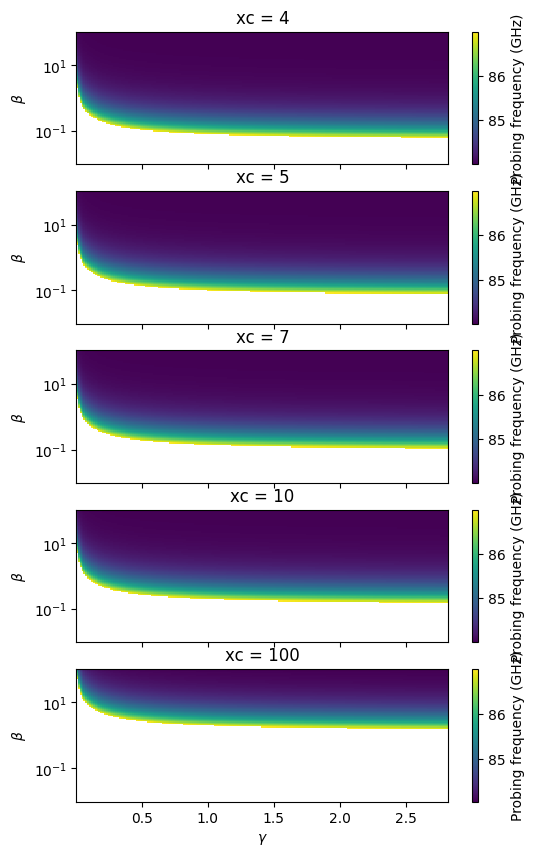

In [5]:
νco_ = wco_*νrel
probRange = (81,87) # GHz

νco_masked_ = np.ma.masked_outside(νco_,probRange[0],probRange[1])

fig,axs = plt.subplots(len(xc_),1,figsize=(6,10),sharex=True)

for i in range(len(νco_masked_)):
    img = axs[i].pcolor(γ_,β_,νco_masked_[i])
    fig.colorbar(img,label='Probing frequency (GHz)')

    axs[i].set_title('xc = '+str(xc_[i]-p0plas))
    axs[i].set_yscale('log')
    axs[i].set_ylabel('$\\beta$')
axs[-1].set_xlabel('$\gamma$')

plt.show()

We can see that the operating frequency is always above $\omega_{ca}$, as we have chosen the upper cutoff frequency for $\omega_{c0}$.

Also, we see that for some values of $\beta$ not all values of $\eta_0$ will be attainable in the chosen frequency range. We can see that the most restictive is $x_c=10$, so we choose according to it $\beta=10$

In [6]:
#np.array([ωco_up(xc,ωp02,ωca2,λ*10*Nx,10*Nx,p0plas) for λ in λ_])*νrel